Model Selection and Cross- Validation for Soil Moisture
---------------------------------------------------

This notebook trains multiple models for soil moisture prediction maps. 
The model training data is based on weekly averaged soil moisture probes and multiple spatial-temporal dependent covariates. 
Here we focus on the top-soil predictions (0-40cm, labeled as 'D1').

The prediction models that are tested are based on Gaussian Process regression with two different base function: Random Forest and Bayesian Linear Regression.

The model selection is based on the cross-validation of the prediction error (normalized RMSE, R2) for the test data.
Test data is selected based on n-fold cross-validation. Different test data is selected for each fold.

Note that test data is n-fold split based on the spatial location of the probes, and not on time. 
The reason why time is not used for the test data selection is that the temporal variability of the soil moisture over short time periods is very low relative to the spatial variations.
If test data would be selected based on unique location in space and time rather than on space only, the model would result in a very low prediction error.

User settings, such as input/output paths and all other options, are set in the settings file, e.g.:

`settings_soilmod_xval_moisture_2021.yaml`

This package is part of the machine learning project developed for the Agricultural Research Federation (AgReFed).

## Library imports

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import yaml
import argparse
from types import SimpleNamespace  
from matplotlib.image import imread

# Custom local libraries:
from utils import print2, truncate_data
from preprocessing import gen_kfold
import GPmodel as gp # GP model plus kernel functions and distance matrix calculation
import model_blr as blr
import model_rf as rf
from soilmod_xval import runmodel


 ## Settings file

 All settings are specified in the .yaml file to make analysis reproducable.

In [2]:
# Define name of settings file to save configuration
fname_settings = 'settings_soilmod_xval_moisture_2021.yaml'
path_settings = 'settings'

### Reading and process settings

In [3]:
# Load settings from yaml file
with open(os.path.join(path_settings,fname_settings), 'r') as f:
    settings = yaml.load(f, Loader=yaml.FullLoader)
# Parse settings dictinary as namespace (settings are available as 
# settings.variable_name rather than settings['variable_name'])
settings = SimpleNamespace(**settings)


# Add temporal or vertical component
if settings.axistype == 'temporal':
    settings.colname_zcoord = settings.colname_tcoord
    settings.colname_zmin = settings.colname_tmin
    settings.colname_zmax =  settings.colname_tmax

if type(settings.model_functions) != list:
    settings.model_functions = [settings.model_functions]

# check if outpath exists, if not create direcory
os.makedirs(settings.outpath, exist_ok = True)

# Intialise output info file:
print2('init')
print2(f'--- Parameter Settings ---')
print2(f'Selected Model Functions: {settings.model_functions}')
print2(f'Target Name: {settings.name_target}')
print2(f'--------------------------')

# Print features selected
print("")
print("--- Features Selected ---")
for key in settings.__dict__:
    if key == "name_features":
        for feature in settings.name_features:
            print(f"'{feature}'")

--- Parameter Settings ---
Selected Model Functions: ['rf-gp', 'blr-gp']
Target Name: D1
--------------------------

--- Features Selected ---
'AVERAGE-Soil-Temp-10cm'
's2_barest_earth_channel1_mean'
'Landscape_Topographic_wetness_index'
'TOTAL-Rain-Gauge'
'Landscape_Slope_median_300m'
'Landscape_MrVBF'
'DEM'


## Data Preprocessing

This includes reading in the dataset from .csv file into pandas dataframe, generating cross-validation test sets, and settings spatial-temporal boundaries.

In [4]:
print('Reading data into dataframe...')
# Read in data
dfsel = pd.read_csv(os.path.join(settings.inpath, settings.infname))

# Rename x and y coordinates of input data
if settings.colname_xcoord != 'x':
    dfsel.rename(columns={settings.colname_xcoord: 'x'}, inplace = True)
if settings.colname_ycoord != 'y':
    dfsel.rename(columns={settings.colname_ycoord: 'y'}, inplace = True)
if (settings.axistype == 'vertical') & (settings.colname_zcoord != 'z'):
    dfsel.rename(columns={settings.colname_zcoord: 'z'}, inplace = True)
else:
    dfsel.rename(columns={settings.colname_tcoord: 'z'}, inplace = True)
    dfsel.rename(columns={settings.colname_zcoord: 'z'}, inplace = True)
settings.name_features.append('z')

# Select data between zmin and zmax
dfsel = dfsel[(dfsel['z'] >= settings.colname_zmin) & (dfsel['z'] <= settings.colname_zmax)]

# Generate n-fold indices
print(f'Generating {settings.nfold}-fold test sets based on moisture probe locations..')
#dfsel = gen_kfold(dfsel, nfold = settings.nfold, label_nfold = 'nfold', id_unique = ['x', 'y', 'z'], precision_unique = 0.01)
dfsel = gen_kfold(dfsel, nfold = settings.nfold, label_nfold = 'nfold', id_unique = ['x', 'y'], precision_unique = 0.01)

## Get coordinates for training data and set coord origin to (0,0)
print(f'Setting coordinate origin to (0,0)...')
bound_xmin = dfsel.x.min()
bound_xmax = dfsel.x.max()
bound_ymin = dfsel.y.min()
bound_ymax = dfsel.y.max()

# Set origin to (0,0)
dfsel['x'] = dfsel['x'] - bound_xmin
dfsel['y'] = dfsel['y'] - bound_ymin

print('Preprocessing data finished.')


Reading data into dataframe...
Generating 8-fold test sets based on moisture probe locations..
Setting coordinate origin to (0,0)...
Preprocessing data finished.


## Train and test multiple models

This might take a couple of minutes given that a new model is trained and evaluated for each cross-validation and model type.

The results for each model are saved as:
- R2
- RMSE normalized to standard deviation
- Theta: Mean ratio of true error squared divided by predicted error squared for test data

In [5]:
# Define stats result lists
nrmse_meanfunction = []
nrmse_meanfunction_std = []
theta_meanfunction = []
theta_meanfunction_std = []
r2_meanfunction = []
r2_meanfunction_std = []

# Loop over model functions and evaluate
for model_function in settings.model_functions:
    # run and evaluate model
    dfsum, stats_summary, model_outpath = runmodel(dfsel, model_function, settings)
    print(f'All output files of {model_function} saved in {model_outpath}')
    print('')
    # save results
    nrmse_meanfunction.append(stats_summary[0])
    nrmse_meanfunction_std.append(stats_summary[1])
    theta_meanfunction.append(stats_summary[2])
    theta_meanfunction_std.append(stats_summary[3])
    r2_meanfunction.append(stats_summary[4])
    r2_meanfunction_std.append(stats_summary[5])


#End of xval loop over all models
#Print best models sorted with nRMSE
ix_meanfunction_sorted = [nrmse_meanfunction.index(x) for x in sorted(nrmse_meanfunction)]
print('')
print('-------------------------------')
print('Models ranked based on nRMSE:')
print('')
for ix in ix_meanfunction_sorted:
    print(f'{settings.model_functions[ix]}: Mean nRMSE = {nrmse_meanfunction[ix]} +/- {nrmse_meanfunction_std[ix]}, Mean R2= {r2_meanfunction[ix]} +/- {r2_meanfunction_std[ix]}, Theta = {theta_meanfunction[ix]} +/- {theta_meanfunction_std[ix]}')

Computing 8-fold xrossvalidation for function model: rf-gp
Processing for nfold  1
Mean of Y:  -0.0001 +/- 0.0067
Mean of Mean function:  0.1972 +/- 0.0273
Mean of Mean function noise: 0.0102 +/- 0.0056
Optimizing GP hyperparameters...
Mean Input Noise:  1.521121616172412
Optimized Hyperparameters (amplitude, y_noise_fac, lengthscale_z, lengths_xy): [1.00595490e-02 1.66100351e-04 2.17545536e+02 3.01441606e+04]
Marginal Log Likelihood:  -1927.2116747643836
Computing GP predictions for test set nfold  1
Logl:  -1927.2116747643836
Logl:  -1927.2116747643836
GP Marginal Log-Likelihood:  -1927.21
Normalized RMSE:  0.5915
Normalized ROOT MEDIAN SE:  0.367
R^2:  0.6501
Mean Theta:  0.9094
Median Theta:  0.0
Processing for nfold  2
Mean of Y:  -0.0001 +/- 0.0071
Mean of Mean function:  0.197 +/- 0.028
Mean of Mean function noise: 0.0104 +/- 0.0059
Optimizing GP hyperparameters...
Mean Input Noise:  1.4660945549011344
Optimized Hyperparameters (amplitude, y_noise_fac, lengthscale_z, lengths_xy)

## Show summary of results

Results for each cross-validation set (here 8) are saved in a separate folder, including result csv files multiple plots for residual analysis and ground truth verssu prediction. To inspect please check images in output folder. Here we show only a few overview results of the combined cross-validation results.

### Results for GP Model with Random-Forest base function

---- Summary stats for GP - RF model model ----
Mean normalized RMSE = 0.673 +/- 0.115
Mean R2 = 0.533 +/- 0.164
Mean Theta = 1.654 +/- 1.144


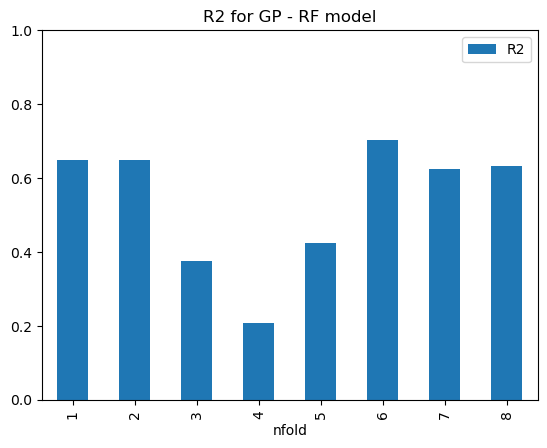

In [30]:
# Read in summary stats
modelname = 'GP - RF model'
respath = os.path.join(settings.outpath, 'Xval_8-fold_rf-gp_D1')

dfstats = pd.read_csv(os.path.join(respath,'D1nfold_summary_stats.csv'))

# print mean nRMSE and R2
print(f'---- Summary stats for {modelname} model ----')
print(f'Mean normalized RMSE = {np.mean(dfstats.nRMSE):.3f} +/- {np.std(dfstats.nRMSE):.3f}')
print(f'Mean R2 = {np.mean(dfstats.R2):.3f} +/- {np.std(dfstats.R2):.3f}')
print(f'Mean Theta = {np.mean(dfstats.Theta):.3f} +/- {np.std(dfstats.Theta):.3f}')

dfstats.plot(y='R2', x = 'nfold', kind = 'bar', title = f'R2 for {modelname}', ylim = (0,1))
plt.show()


Image files generated:  ['Xvalidation_Residual_hist_D1.png', 'pred_vs_trueD1_combined.png']


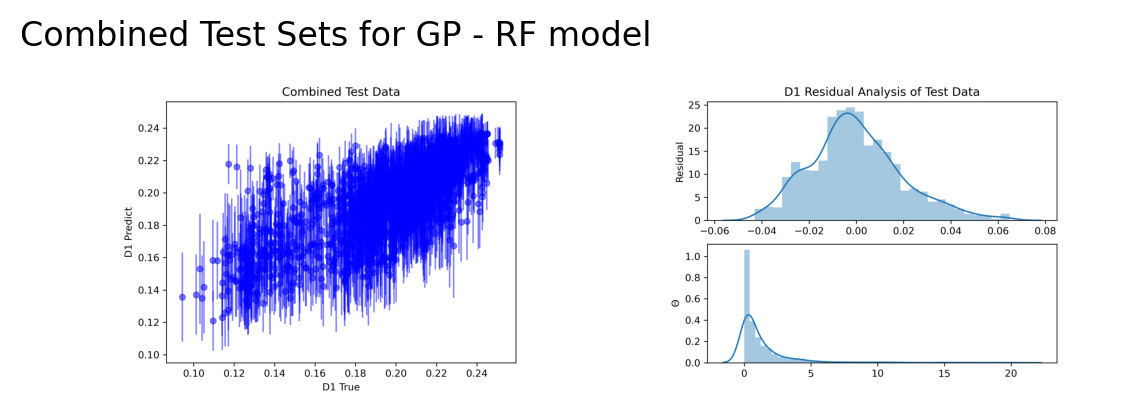

In [31]:
# Plot combined test data
files = os.listdir(respath)
pngfiles = [name for name in files if name.endswith('.png')]
print('Image files generated: ', pngfiles)
fig, ax = plt.subplots(1,2, dpi =200)
img = imread(f"{respath}/pred_vs_trueD1_combined.png", format='PNG')
ax[0].set_axis_off()
ax[0].imshow(img)
ax[0].set_title(f'Combined Test Sets for {modelname}')
img2 = imread(f"{respath}/Xvalidation_Residual_hist_D1.png", format='PNG')
ax[1].set_axis_off()
ax[1].imshow(img2)
#ax[1].set_title('')
fig.show()


Best R2 result for X-val fold: 6
Worst R2 result for X-val fold: 4


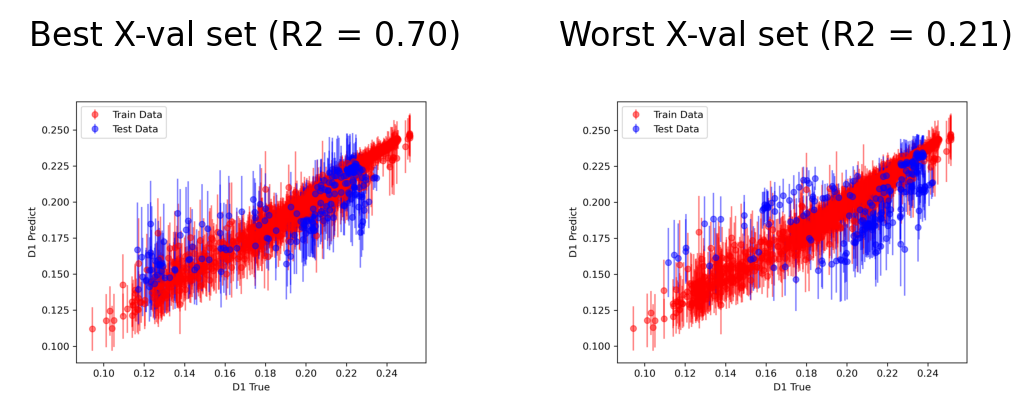

In [38]:
# Plot best and worst X-validation results based on R2
fold_top = dfstats.loc[np.argmax(dfstats.R2), 'nfold']
print('Best R2 result for X-val fold:', fold_top)
fold_bottom = dfstats.loc[np.argmin(dfstats.R2), 'nfold']
print('Worst R2 result for X-val fold:', fold_bottom)

fig, ax = plt.subplots(1,2, dpi =200)
img = imread(f"{respath}/nfold_{fold_top}/pred_vs_trueD1_nfold{fold_top}.png", format='PNG')
ax[0].set_axis_off()
ax[0].imshow(img)
ax[0].set_title(f'Best X-val set (R2 = {np.max(dfstats.R2):.2f})')
img2 = imread(f"{respath}/nfold_{fold_bottom}/pred_vs_trueD1_nfold{fold_bottom}.png", format='PNG')
ax[1].set_axis_off()
ax[1].imshow(img2)
ax[1].set_title(f'Worst X-val set (R2 = {np.min(dfstats.R2):.2f})')
fig.show()



### Results for GP Model with Bayesian Regression base function

---- Summary stats for GP - BLR model model ----
Mean normalized RMSE = 0.843 +/- 0.170
Mean R2 = 0.261 +/- 0.326
Mean Theta = 0.847 +/- 0.492


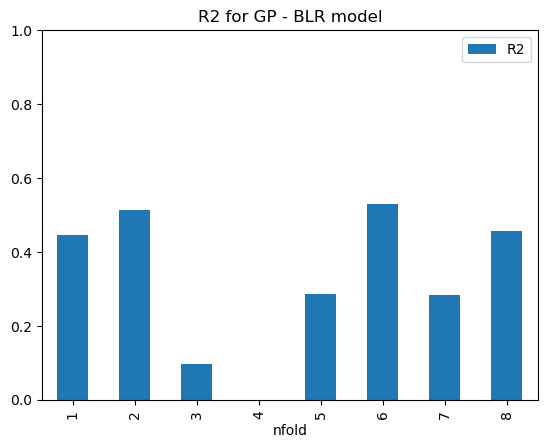

In [43]:
# Read in summary stats
modelname = 'GP - BLR model'
respath = os.path.join(settings.outpath, 'Xval_8-fold_blr-gp_D1')

dfstats = pd.read_csv(os.path.join(respath,'D1nfold_summary_stats.csv'))

# print mean nRMSE and R2
print(f'---- Summary stats for {modelname} model ----')
print(f'Mean normalized RMSE = {np.mean(dfstats.nRMSE):.3f} +/- {np.std(dfstats.nRMSE):.3f}')
print(f'Mean R2 = {np.mean(dfstats.R2):.3f} +/- {np.std(dfstats.R2):.3f}')
print(f'Mean Theta = {np.mean(dfstats.Theta):.3f} +/- {np.std(dfstats.Theta):.3f}')

dfstats.plot(y='R2', x = 'nfold', kind = 'bar', title = f'R2 for {modelname}', ylim = (0,1))
plt.show()

Image files generated:  ['Xvalidation_Residual_hist_D1.png', 'pred_vs_trueD1_combined.png']


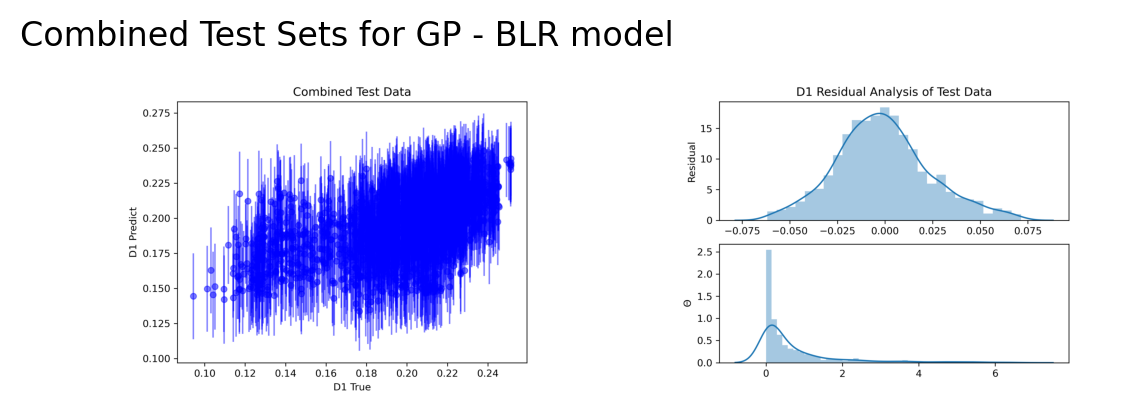

In [44]:
# Plot combined test data
files = os.listdir(respath)
pngfiles = [name for name in files if name.endswith('.png')]
print('Image files generated: ', pngfiles)
fig, ax = plt.subplots(1,2, dpi =200)
img = imread(f"{respath}/pred_vs_trueD1_combined.png", format='PNG')
ax[0].set_axis_off()
ax[0].imshow(img)
ax[0].set_title(f'Combined Test Sets for {modelname}')
img2 = imread(f"{respath}/Xvalidation_Residual_hist_D1.png", format='PNG')
ax[1].set_axis_off()
ax[1].imshow(img2)
#ax[1].set_title('')
fig.show()

Best R2 result for X-val fold: 6
Worst R2 result for X-val fold: 4


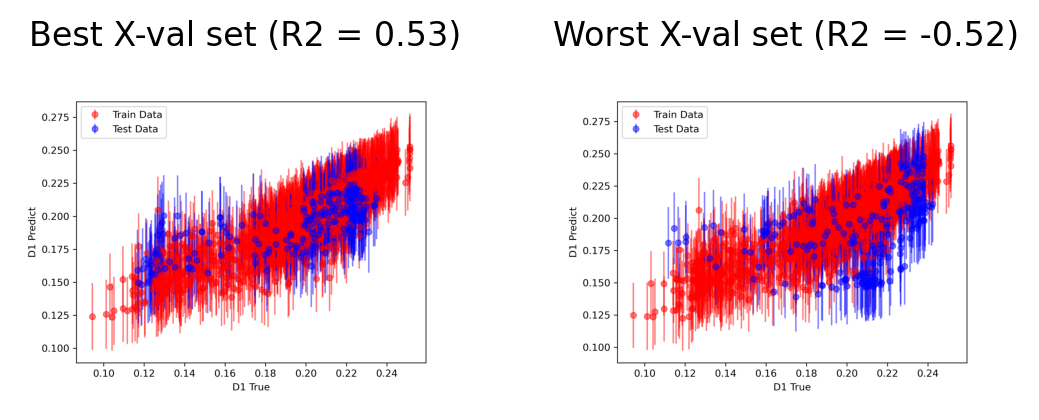

In [45]:
# Plot best and worst X-validation results based on R2
fold_top = dfstats.loc[np.argmax(dfstats.R2), 'nfold']
print('Best R2 result for X-val fold:', fold_top)
fold_bottom = dfstats.loc[np.argmin(dfstats.R2), 'nfold']
print('Worst R2 result for X-val fold:', fold_bottom)

fig, ax = plt.subplots(1,2, dpi =200)
img = imread(f"{respath}/nfold_{fold_top}/pred_vs_trueD1_nfold{fold_top}.png", format='PNG')
ax[0].set_axis_off()
ax[0].imshow(img)
ax[0].set_title(f'Best X-val set (R2 = {np.max(dfstats.R2):.2f})')
img2 = imread(f"{respath}/nfold_{fold_bottom}/pred_vs_trueD1_nfold{fold_bottom}.png", format='PNG')
ax[1].set_axis_off()
ax[1].imshow(img2)
ax[1].set_title(f'Worst X-val set (R2 = {np.min(dfstats.R2):.2f})')
fig.show()

## Conclusion

For soil moisture modeling, the results of the cross-validation indicate that the GP model with the Random Forest (R2 = 0.533 +/- 0.164) as base function provides more accurate results than the Bayesian Linear Regression base function (R2 = 0.261 +/- 0.326). 